In [29]:
%load_ext autoreload
%autoreload 2

# Imports
import tensorflow as tf
import recommender
from recommender import Recommender, FactorizationRecommender, BPRRecommender, ImplicitBPRRecommender, WalsRecommender, ImplicitWalsRecommender
from matrix_builder import ReportTechniqueMatrixBuilder
from tie import TechniqueInferenceEngine
import random
import math
import importlib
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

assert tf.executing_eagerly()

importlib.reload(recommender)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'recommender' from '/Users/mjturner/code/technique-inference-engine/models/recommender/__init__.py'>

In [22]:
validation_ratio = 0.1
test_ratio = 0.2

# data locations
dataset_filepath = "../data/combined_dataset_parent_only.json"
enterprise_attack_filepath = "../enterprise-attack.json"

# make data
data_builder = ReportTechniqueMatrixBuilder(
    combined_dataset_filepath=dataset_filepath,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
data = data_builder.build()
# split into training and test data
train_and_validation_indices = frozenset(random.sample(data.indices, k=math.floor((1-test_ratio) * len(data.indices))))
validation_indices = frozenset(random.sample(tuple(train_and_validation_indices), k=math.floor((1-validation_ratio) * len(train_and_validation_indices))))
train_indices = frozenset(train_and_validation_indices).difference(validation_indices)
test_indices = frozenset(data.indices).difference(train_and_validation_indices)
training_data = data.mask(train_indices)
validation_data = data.mask(validation_indices)
test_data = data.mask(test_indices)

(6262, 200)


In [27]:

def test_multiple_embeding_dimensions(model_class: Recommender, out_file: str, **kwargs):
    """Runs model_class at multiple embedding dimensions and saves results.

    Runs each model for embedding dimensions 4, 8, 10, 16, 32, and 64.

    Args:
        model_class: A model on which to train at multiple embedding dimensions.
        out_file: filename for saving the results file.  Requires len(out_file) > 0
            and out_file is a valid csv filename.
        kwargs: Parameters mapped to values.

    Mutates:
        Saves model results, including embedding_dimension, hyperparameters,
        and precision, recall, and ndcg at 10, 20, 50, and 100 to out_file.
    """
    assert len(out_file) > 0

    results = []

    embedding_dimensions = (4,8,10,16,32,64)
    # for every embedding
    for embedding_dimension in embedding_dimensions:

        # make model
        model = model_class(
            m=training_data.m,
            n=training_data.n,
            k=embedding_dimension,
        )

        # make tie
        tie = TechniqueInferenceEngine(
            training_data=training_data,
            validation_data=validation_data,
            test_data=test_data,
            model=model,
            enterprise_attack_filepath=enterprise_attack_filepath,
        )

        # fit hyperparameters
        best_hyperparameters = tie.fit_with_cross_validation(**kwargs)

        # calculate precision, recall, ndcg
        run_stats = {
            "embedding_dimension": embedding_dimension,
            **best_hyperparameters
        }
        k_values = (10, 20, 50, 100)
        for k in k_values:
            run_stats[f"precision_at_{k}"] = tie.precision(k=k)
            run_stats[f"recall_at_{k}"] = tie.recall(k=k)
            run_stats[f"ndcg_at_{k}"] = tie.normalized_discounted_cumulative_gain(k=k)

        print(run_stats)
        results.append(run_stats)


    # save as csv
    results_dataframe = pd.DataFrame(results)
    results_dataframe.to_csv(out_file)

In [28]:
test_multiple_embeding_dimensions(
    model_class=WalsRecommender,
    out_file="wals_model_results.csv",
    num_iterations=[20],
    c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    regularization_coefficient=[0.0, 0.0001, 0.001, 0.01]
)

{'embedding_dimension': 4, 'regularization_coefficient': 0.001, 'c': 0.3, 'num_iterations': 20, 'precision_at_10': 0.07499201533056532, 'recall_at_10': 0.36999110226513615, 'ndcg_at_10': 0.09590677937233659, 'precision_at_20': 0.07499201533056532, 'recall_at_20': 0.4032120688141129, 'ndcg_at_20': 0.13423200343057676, 'precision_at_50': 0.02141488342382625, 'recall_at_50': 0.46802315334333855, 'ndcg_at_50': 0.19148667223852067, 'precision_at_100': 0.012080804854679017, 'recall_at_100': 0.5104516393681197, 'ndcg_at_100': 0.23720523863799173}
{'embedding_dimension': 8, 'regularization_coefficient': 0.001, 'c': 0.05, 'num_iterations': 20, 'precision_at_10': 0.07192590226764613, 'recall_at_10': 0.3601439384455992, 'ndcg_at_10': 0.07737279783928498, 'precision_at_20': 0.07192590226764613, 'recall_at_20': 0.3955803152984565, 'ndcg_at_20': 0.11640051328298764, 'precision_at_50': 0.02007026509102523, 'recall_at_50': 0.44828805682766076, 'ndcg_at_50': 0.16603337234750756, 'precision_at_100': 0.0

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.017511990762643623]
recalls [0.017511990762643623, 0.017056864604866558]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391, 0.015592374837917514]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391, 0.015592374837917514, 0.015098777091046053]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391, 0.015592374837917514, 0.015098777091046053, 0.014621027703204042]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391, 0.015592374837917514, 0.015098777091046053, 0.014621027703204042, 0.014873992560129294]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391, 0.015592374837917514, 0.015098777091046053, 0.014621027703204042, 0.014873992560129294, 0.014224129186695179]
recalls [0.017511990762643623, 0.017056864604866558, 0.01602418069131391, 0.015592374837917514, 0.015098777091046053, 0.014621027703204042, 0.

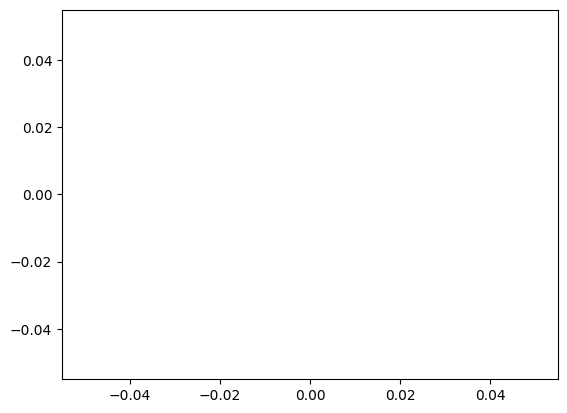

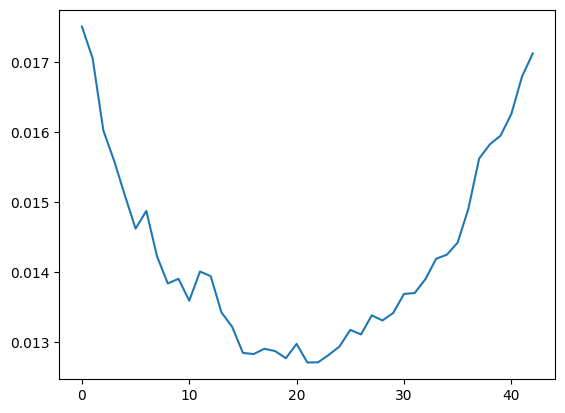

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.01747214297247645]
recalls [0.01747214297247645, 0.018755203306159585]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363, 0.022308332744882805]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363, 0.022308332744882805, 0.025301346196404152]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363, 0.022308332744882805, 0.025301346196404152, 0.03008181848326418]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363, 0.022308332744882805, 0.025301346196404152, 0.03008181848326418, 0.03560898410305196]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363, 0.022308332744882805, 0.025301346196404152, 0.03008181848326418, 0.03560898410305196, 0.042173206193463764]
recalls [0.01747214297247645, 0.018755203306159585, 0.020239844857872363, 0.022308332744882805, 0.025301346196404152, 0.03008181848326418, 0.03560898

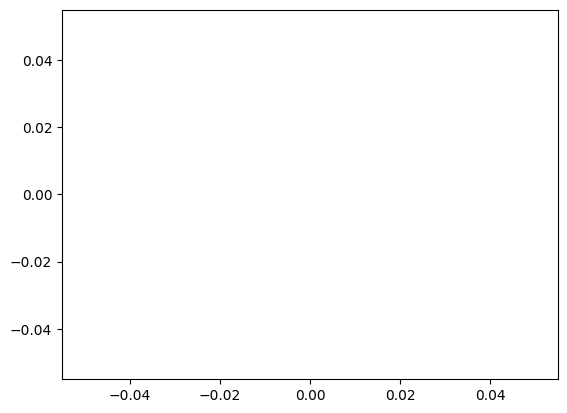

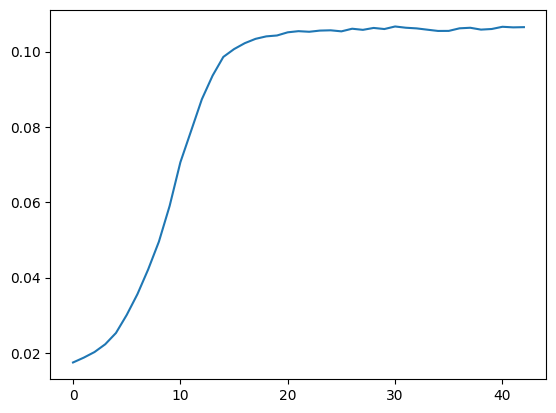

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.10598597050573962]
recalls [0.10598597050573962, 0.10775089132607403]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403, 0.10824100192876847]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403, 0.10824100192876847, 0.10685332682662516]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403, 0.10824100192876847, 0.10685332682662516, 0.10576661692953707]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403, 0.10824100192876847, 0.10685332682662516, 0.10576661692953707, 0.10717927946484411]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403, 0.10824100192876847, 0.10685332682662516, 0.10576661692953707, 0.10717927946484411, 0.10692579789548905]
recalls [0.10598597050573962, 0.10775089132607403, 0.10774017596882403, 0.10824100192876847, 0.10685332682662516, 0.10576661692953707, 0.10717927946484411, 0.10692579789548

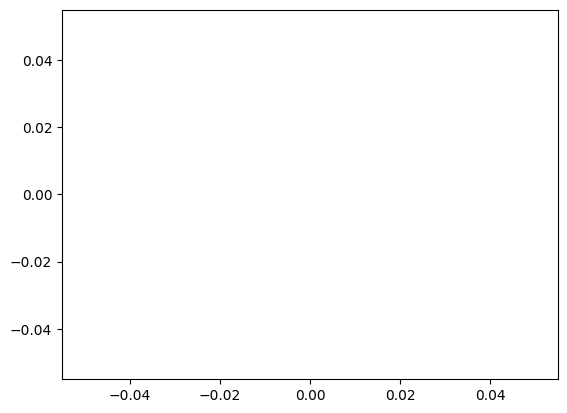

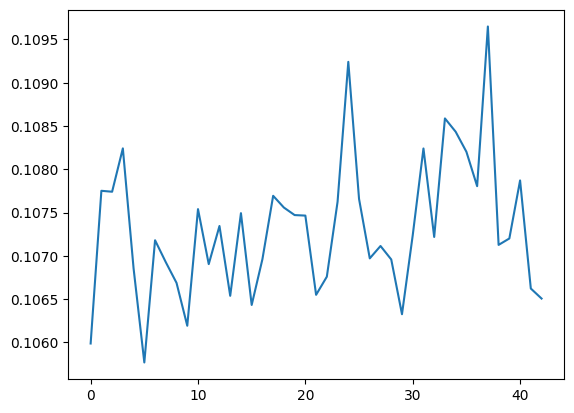

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.10804423109961184]
recalls [0.10804423109961184, 0.10490955880572522]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668, 0.10550756335355788]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668, 0.10550756335355788, 0.10625628393948515]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668, 0.10550756335355788, 0.10625628393948515, 0.10719987424279888]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668, 0.10550756335355788, 0.10625628393948515, 0.10719987424279888, 0.10637819366366438]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668, 0.10550756335355788, 0.10625628393948515, 0.10719987424279888, 0.10637819366366438, 0.1068620336343954]
recalls [0.10804423109961184, 0.10490955880572522, 0.1077815471769668, 0.10550756335355788, 0.10625628393948515, 0.10719987424279888, 0.10637819366366438, 0.1068620336343954, 0.10

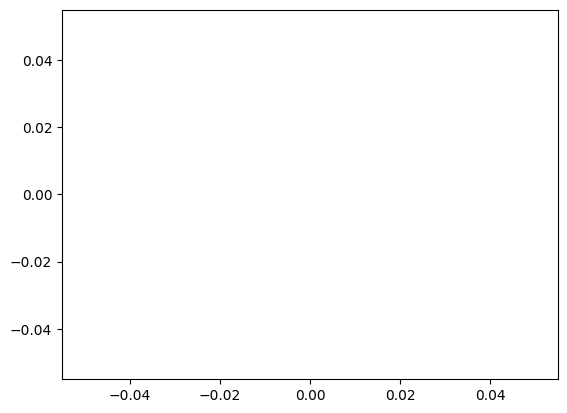

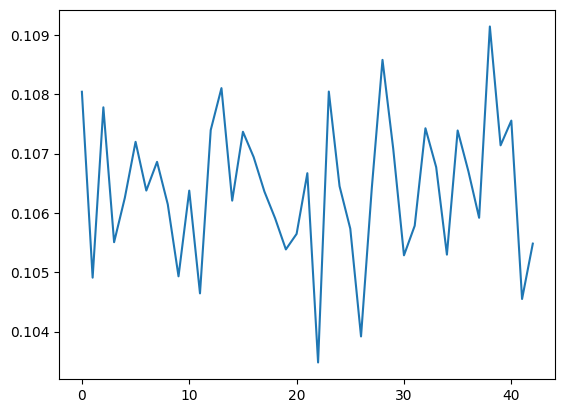

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.10814459090204952]
recalls [0.10814459090204952, 0.10663651145490718]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249, 0.10530828753006875]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249, 0.10530828753006875, 0.10510466354880374]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249, 0.10530828753006875, 0.10510466354880374, 0.10418161617494191]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249, 0.10530828753006875, 0.10510466354880374, 0.10418161617494191, 0.10397966448384939]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249, 0.10530828753006875, 0.10510466354880374, 0.10418161617494191, 0.10397966448384939, 0.10301077964470133]
recalls [0.10814459090204952, 0.10663651145490718, 0.1057967367649249, 0.10530828753006875, 0.10510466354880374, 0.10418161617494191, 0.10397966448384939, 0.10301077964470133, 0.

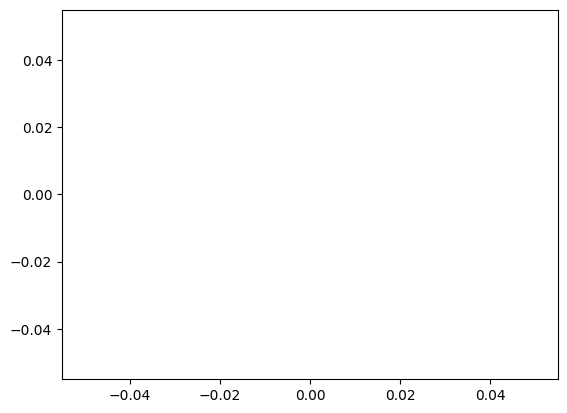

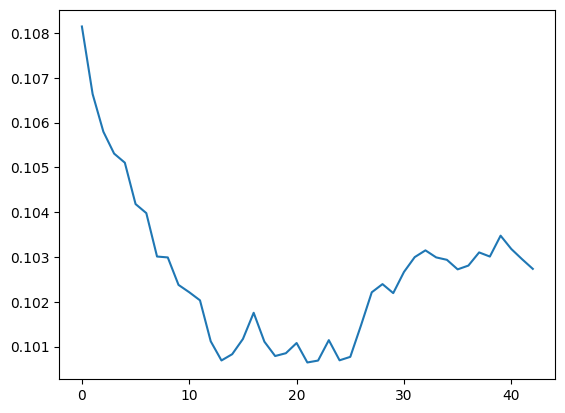

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.10251000648472797]
recalls [0.10251000648472797, 0.10274295604696529]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306, 0.10398729308258306]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306, 0.10398729308258306, 0.10548846455740514]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306, 0.10398729308258306, 0.10548846455740514, 0.10747094391133132]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306, 0.10398729308258306, 0.10548846455740514, 0.10747094391133132, 0.1092140635441028]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306, 0.10398729308258306, 0.10548846455740514, 0.10747094391133132, 0.1092140635441028, 0.10988129040503777]
recalls [0.10251000648472797, 0.10274295604696529, 0.1031246261707306, 0.10398729308258306, 0.10548846455740514, 0.10747094391133132, 0.1092140635441028, 0.10988129040503777, 0.110

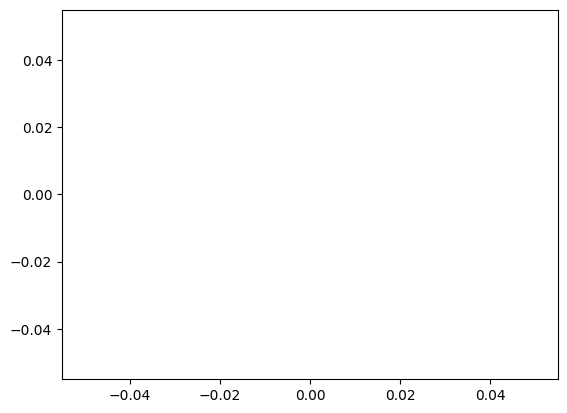

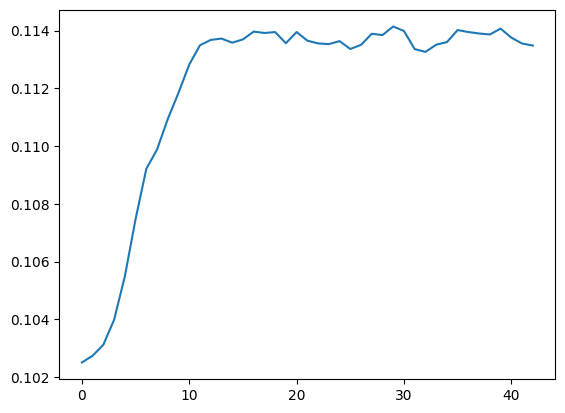

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.11364938262858962]
recalls [0.11364938262858962, 0.11802961267882736]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609, 0.12040910754075596]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609, 0.12040910754075596, 0.12073284620358943]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609, 0.12040910754075596, 0.12073284620358943, 0.11975169732968877]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609, 0.12040910754075596, 0.12073284620358943, 0.11975169732968877, 0.1199095587379494]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609, 0.12040910754075596, 0.12073284620358943, 0.11975169732968877, 0.1199095587379494, 0.12032222673285949]
recalls [0.11364938262858962, 0.11802961267882736, 0.11942160095599609, 0.12040910754075596, 0.12073284620358943, 0.11975169732968877, 0.1199095587379494, 0.12032222673285949

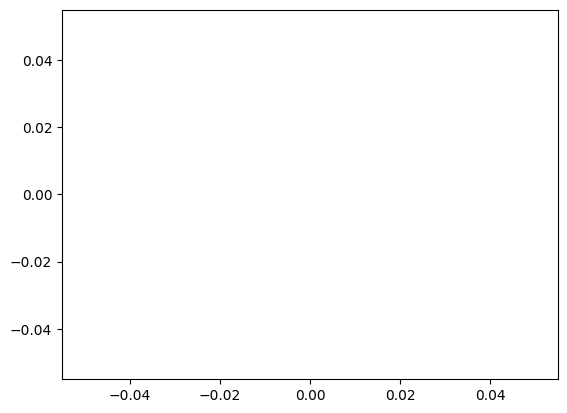

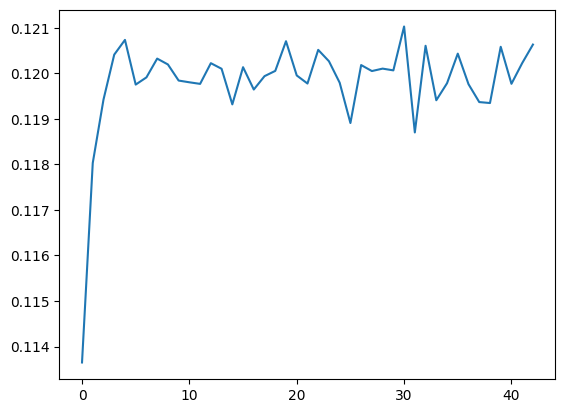

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.11966798504140924]
recalls [0.11966798504140924, 0.1201298187114831]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081, 0.12035092775964422]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081, 0.12035092775964422, 0.12151744994181633]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081, 0.12035092775964422, 0.12151744994181633, 0.12219352399770703]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081, 0.12035092775964422, 0.12151744994181633, 0.12219352399770703, 0.12112861497537036]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081, 0.12035092775964422, 0.12151744994181633, 0.12219352399770703, 0.12112861497537036, 0.12132607135695324]
recalls [0.11966798504140924, 0.1201298187114831, 0.12131612796630081, 0.12035092775964422, 0.12151744994181633, 0.12219352399770703, 0.12112861497537036, 0.12132607135695324, 0.1

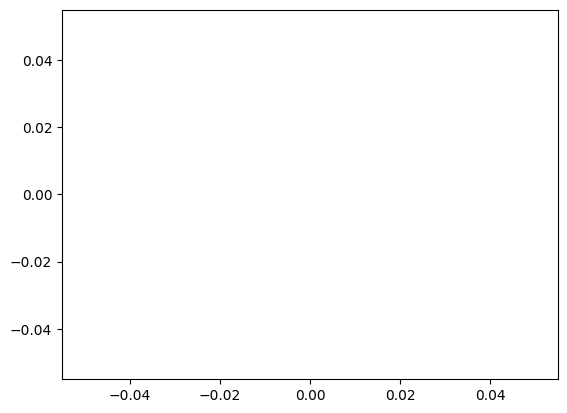

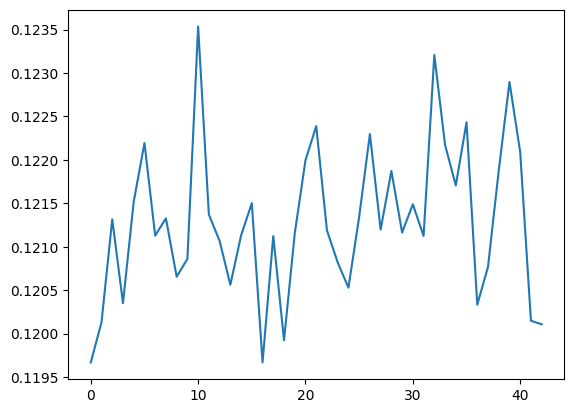

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.12185792931056141]
recalls [0.12185792931056141, 0.11767593675823991]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999, 0.11205797348767552]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999, 0.11205797348767552, 0.11037098451228028]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999, 0.11205797348767552, 0.11037098451228028, 0.1090037533868907]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999, 0.11205797348767552, 0.11037098451228028, 0.1090037533868907, 0.10685764193065468]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999, 0.11205797348767552, 0.11037098451228028, 0.1090037533868907, 0.10685764193065468, 0.10562902075233693]
recalls [0.12185792931056141, 0.11767593675823991, 0.11508395580940999, 0.11205797348767552, 0.11037098451228028, 0.1090037533868907, 0.10685764193065468, 0.10562902075233693,

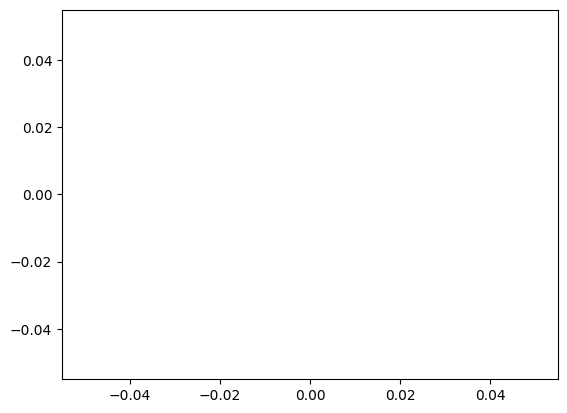

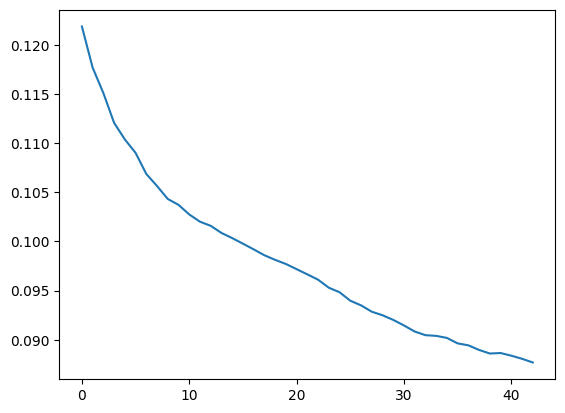

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.08765916849103014]
recalls [0.08765916849103014, 0.08781974906521658]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108, 0.08938606530336292]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108, 0.08938606530336292, 0.0927758548317663]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108, 0.08938606530336292, 0.0927758548317663, 0.09512701337902832]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108, 0.08938606530336292, 0.0927758548317663, 0.09512701337902832, 0.09785863158693207]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108, 0.08938606530336292, 0.0927758548317663, 0.09512701337902832, 0.09785863158693207, 0.09965057108177612]
recalls [0.08765916849103014, 0.08781974906521658, 0.08834958891556108, 0.08938606530336292, 0.0927758548317663, 0.09512701337902832, 0.09785863158693207, 0.09965057108177612, 

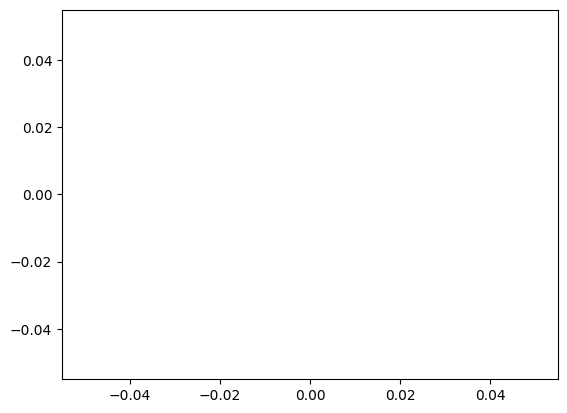

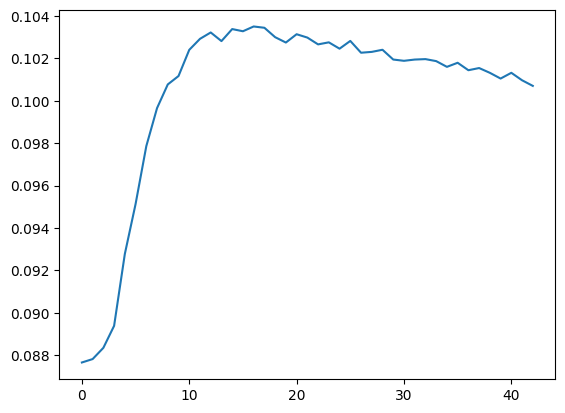

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.10076450159925184]
recalls [0.10076450159925184, 0.1127482760344137]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217, 0.11518620814736977]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217, 0.11518620814736977, 0.11396315957523147]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217, 0.11518620814736977, 0.11396315957523147, 0.11479134723270687]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217, 0.11518620814736977, 0.11396315957523147, 0.11479134723270687, 0.11412976033669009]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217, 0.11518620814736977, 0.11396315957523147, 0.11479134723270687, 0.11412976033669009, 0.11444002177758071]
recalls [0.10076450159925184, 0.1127482760344137, 0.11402576952286217, 0.11518620814736977, 0.11396315957523147, 0.11479134723270687, 0.11412976033669009, 0.11444002177758071, 0.1

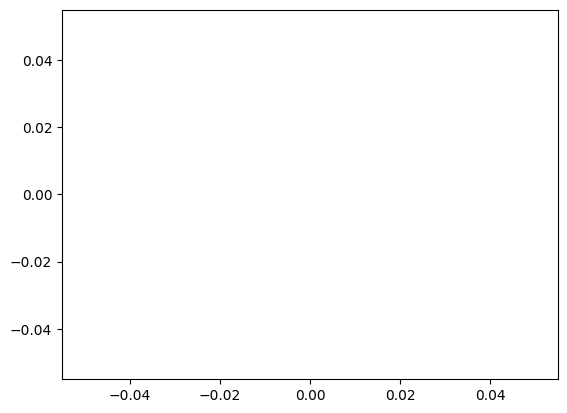

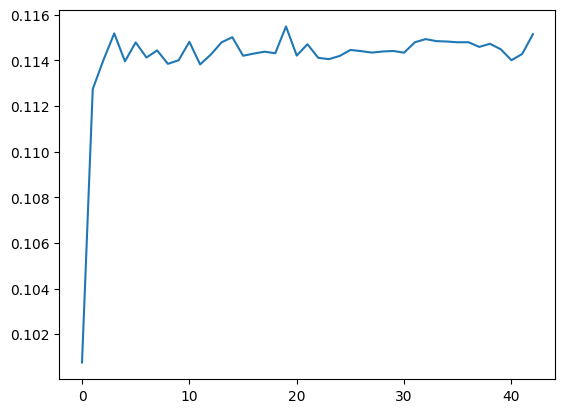

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.11425391268457288]
recalls [0.11425391268457288, 0.11971276502141946]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632, 0.12021694901260253]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632, 0.12021694901260253, 0.12167565656361286]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632, 0.12021694901260253, 0.12167565656361286, 0.11993682595421376]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632, 0.12021694901260253, 0.12167565656361286, 0.11993682595421376, 0.1196770177596403]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632, 0.12021694901260253, 0.12167565656361286, 0.11993682595421376, 0.1196770177596403, 0.12054754260014279]
recalls [0.11425391268457288, 0.11971276502141946, 0.11987689949896632, 0.12021694901260253, 0.12167565656361286, 0.11993682595421376, 0.1196770177596403, 0.12054754260014279

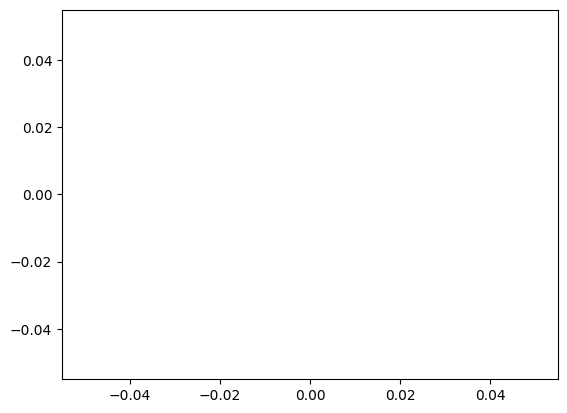

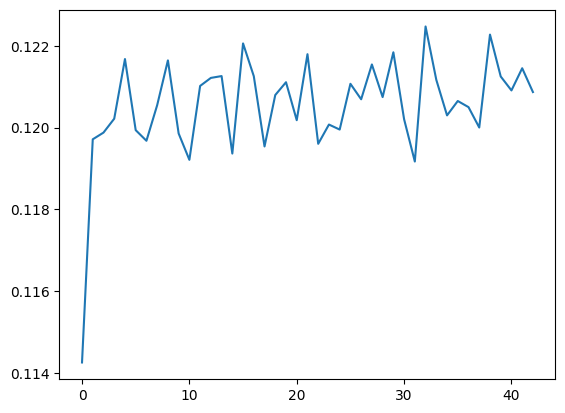

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.12019794764419203]
recalls [0.12019794764419203, 0.09120718990075707]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747, 0.08060158722463567]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747, 0.08060158722463567, 0.079682752209266]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747, 0.08060158722463567, 0.079682752209266, 0.07879146315125705]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747, 0.08060158722463567, 0.079682752209266, 0.07879146315125705, 0.07807529883720069]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747, 0.08060158722463567, 0.079682752209266, 0.07879146315125705, 0.07807529883720069, 0.0772497727362035]
recalls [0.12019794764419203, 0.09120718990075707, 0.0845659561003747, 0.08060158722463567, 0.079682752209266, 0.07879146315125705, 0.07807529883720069, 0.0772497727362035, 0.077155487341

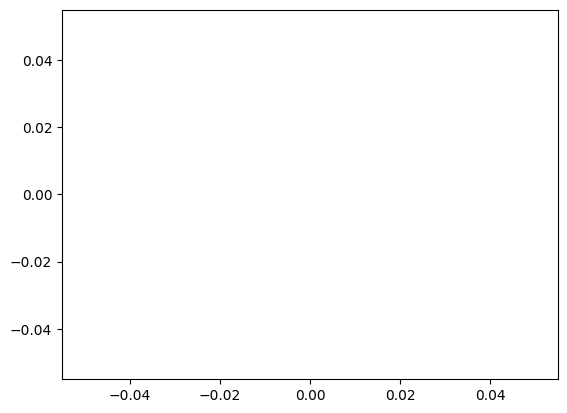

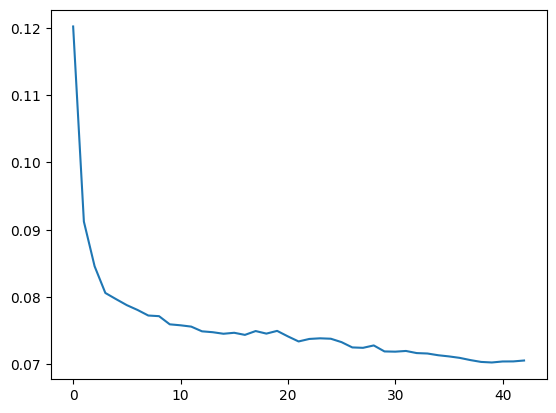

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.06997097508820882]
recalls [0.06997097508820882, 0.07282327644737699]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784, 0.08009356746088105]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784, 0.08009356746088105, 0.08181870541246422]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784, 0.08009356746088105, 0.08181870541246422, 0.08290759886402135]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784, 0.08009356746088105, 0.08181870541246422, 0.08290759886402135, 0.08377165416356054]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784, 0.08009356746088105, 0.08181870541246422, 0.08290759886402135, 0.08377165416356054, 0.08374934778545727]
recalls [0.06997097508820882, 0.07282327644737699, 0.07598266733902784, 0.08009356746088105, 0.08181870541246422, 0.08290759886402135, 0.08377165416356054, 0.08374934778545

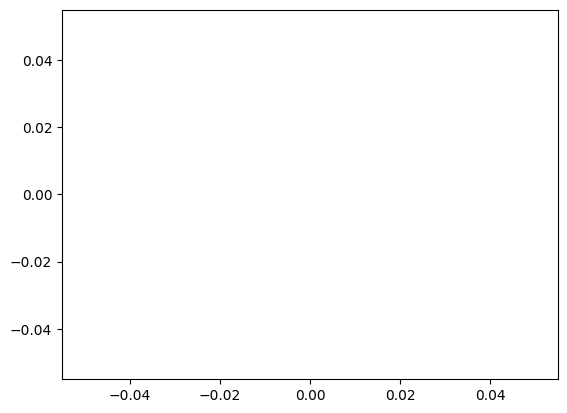

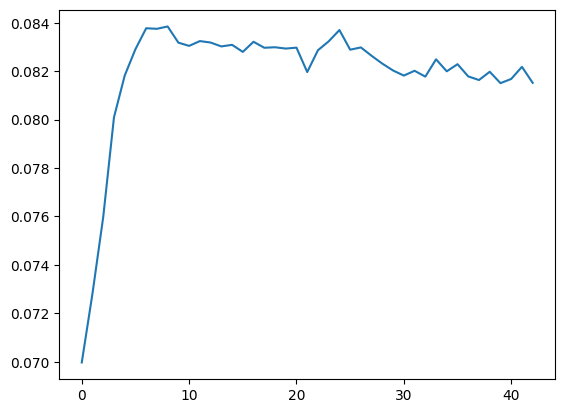

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.08126082416350983]
recalls [0.08126082416350983, 0.09341864775338388]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086, 0.09314713730740841]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086, 0.09314713730740841, 0.09353299386541444]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086, 0.09314713730740841, 0.09353299386541444, 0.0931083973260641]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086, 0.09314713730740841, 0.09353299386541444, 0.0931083973260641, 0.09317706304327286]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086, 0.09314713730740841, 0.09353299386541444, 0.0931083973260641, 0.09317706304327286, 0.09286596287660126]
recalls [0.08126082416350983, 0.09341864775338388, 0.0931396912863086, 0.09314713730740841, 0.09353299386541444, 0.0931083973260641, 0.09317706304327286, 0.09286596287660126, 0.0929

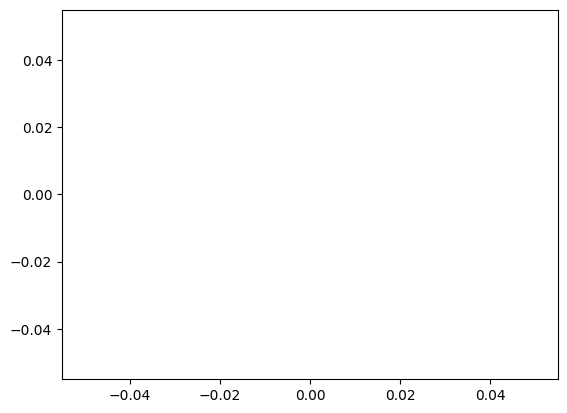

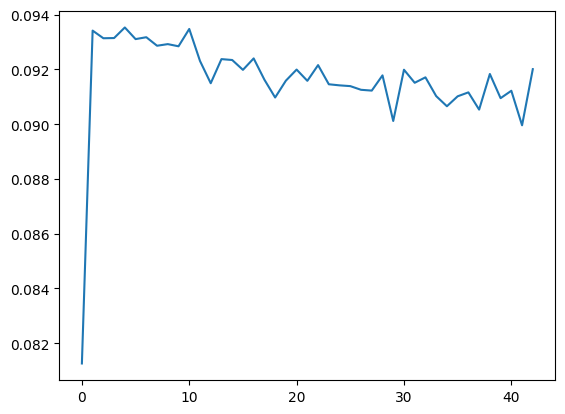

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.09027898818876612]
recalls [0.09027898818876612, 0.10406464728202287]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886, 0.10561359427172361]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886, 0.10561359427172361, 0.10476596225264664]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886, 0.10561359427172361, 0.10476596225264664, 0.10501367651674356]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886, 0.10561359427172361, 0.10476596225264664, 0.10501367651674356, 0.10529321306664104]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886, 0.10561359427172361, 0.10476596225264664, 0.10501367651674356, 0.10529321306664104, 0.10509760594832551]
recalls [0.09027898818876612, 0.10406464728202287, 0.1044809907596886, 0.10561359427172361, 0.10476596225264664, 0.10501367651674356, 0.10529321306664104, 0.10509760594832551, 0.

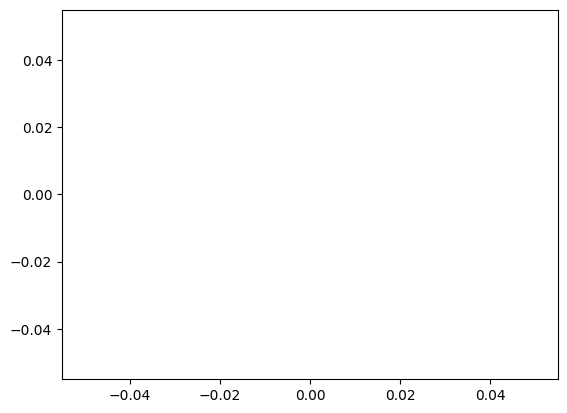

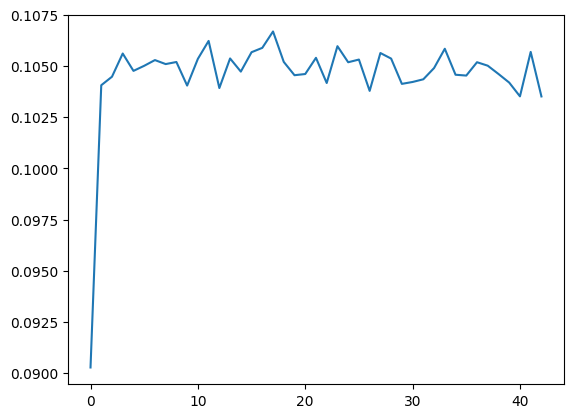

/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.10359730554920496]
recalls [0.10359730554920496, 0.11870535488083914]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315, 0.11960226374045958]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315, 0.11960226374045958, 0.11826331470908003]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315, 0.11960226374045958, 0.11826331470908003, 0.11803369785338523]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315, 0.11960226374045958, 0.11826331470908003, 0.11803369785338523, 0.11908437319741734]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315, 0.11960226374045958, 0.11826331470908003, 0.11803369785338523, 0.11908437319741734, 0.11857061265221126]
recalls [0.10359730554920496, 0.11870535488083914, 0.11883741877847315, 0.11960226374045958, 0.11826331470908003, 0.11803369785338523, 0.11908437319741734, 0.11857061265221

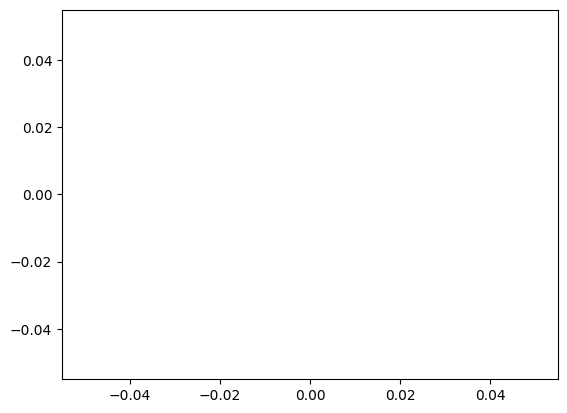

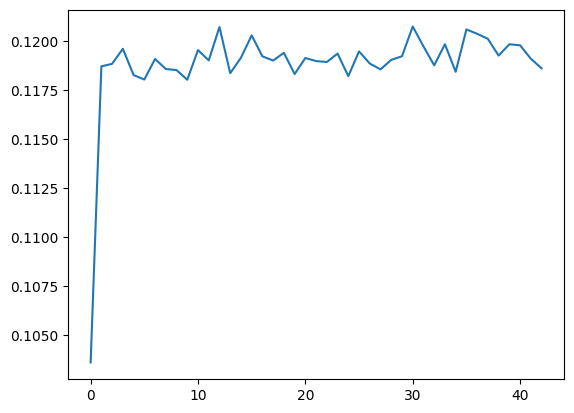

{'embedding_dimension': 4, 'regularization': 0.01, 'learning_rate': 5e-05, 'num_iterations': 76521640, 'precision_at_10': 0.01970616416480358, 'recall_at_10': 0.07792608808704962, 'ndcg_at_10': 0.09268988004845001, 'precision_at_20': 0.01970616416480358, 'recall_at_20': 0.11946727388244381, 'ndcg_at_20': 0.11998749577701283, 'precision_at_50': 0.010274672628553179, 'recall_at_50': 0.18971364007764707, 'ndcg_at_50': 0.15749198706810608, 'precision_at_100': 0.006702331523474928, 'recall_at_100': 0.2467694880034952, 'ndcg_at_100': 0.18145809496526322}


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.019532983048914813]
recalls [0.019532983048914813, 0.01940763641286872]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022, 0.018940222159922686]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022, 0.018940222159922686, 0.01868293836702727]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022, 0.018940222159922686, 0.01868293836702727, 0.018492637078833935]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022, 0.018940222159922686, 0.01868293836702727, 0.018492637078833935, 0.018294541232382926]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022, 0.018940222159922686, 0.01868293836702727, 0.018492637078833935, 0.018294541232382926, 0.01801444409824555]
recalls [0.019532983048914813, 0.01940763641286872, 0.019596485942983022, 0.018940222159922686, 0.01868293836702727, 0.018492637078833935, 0.0182945

KeyboardInterrupt: 

In [19]:
test_multiple_embeding_dimensions(
    BPRRecommender,
    out_file="bpr_model_results.csv",
    num_iterations=[20*training_data.m*training_data.n],
    learning_rate=[0.00001, 0.00005, 0.0001, 0.001],
    regularization=[0., 0.0001, 0.001, 0.01],
)

In [4]:
embedding_dimension = 10
k = 20
best_hyperparameters = {'gravity_coefficient': 0.001, 'regularization_coefficient': 0.5, 'num_iterations': 1000, 'learning_rate': 100.0}

model = FactorizationRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.01, 0.1, 1.0, 10., 20., 50., 100.],
#     num_iterations=[1000],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
#     gravity_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.5349124
Precision 0.014092941552219736
Recall 0.10305401611477227
Normalized Discounted Cumulative Gain 0.10037612496152852


/Users/mjturner/code/technique-inference-engine/models/recommender/bpr_recommender.py:103: RuntimeWarning: invalid value encountered in divide
  data / np.expand_dims(num_items_per_user, axis=1)


recalls [0.018741711773091523]
recalls [0.018741711773091523, 0.01698032595709057]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063, 0.025496814035408166]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063, 0.025496814035408166, 0.039719389982766654]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063, 0.025496814035408166, 0.039719389982766654, 0.058817671195670135]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063, 0.025496814035408166, 0.039719389982766654, 0.058817671195670135, 0.07564849937200906]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063, 0.025496814035408166, 0.039719389982766654, 0.058817671195670135, 0.07564849937200906, 0.08760261883571012]
recalls [0.018741711773091523, 0.01698032595709057, 0.018858808736244063, 0.025496814035408166, 0.039719389982766654, 0.058817671195670135, 0.0756

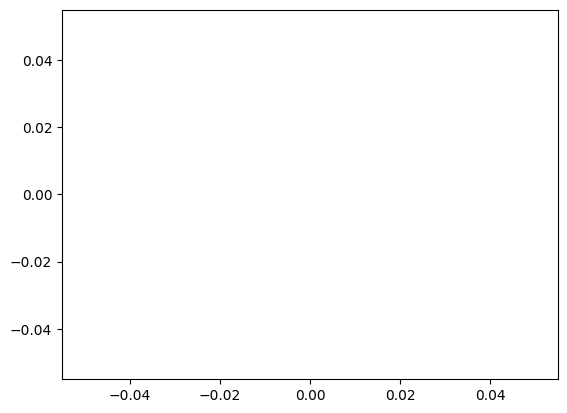

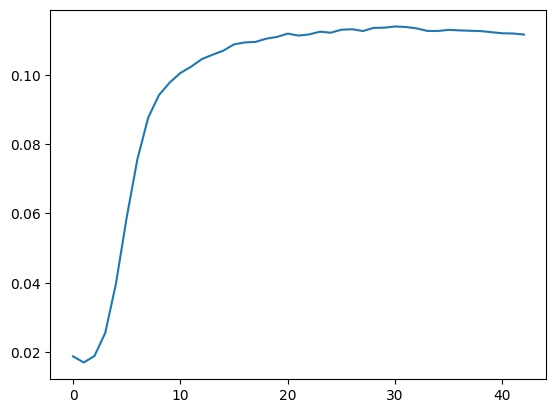

Mean Squared Error 1.087095
Precision 0.014667837751517088
Recall 0.11127964199760468
Normalized Discounted Cumulative Gain 0.10735959722249395


In [16]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.0001}
best_hyperparameters["num_iterations"] = 20*training_data.m*training_data.n

model = BPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[500 * 512],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=20)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

In [7]:
# hyperparameters
embedding_dimension = 10
k = 20
best_hyperparameters = {'regularization': 0.0001, 'num_iterations': 256000, 'learning_rate': 0.005}

best_hyperparameters["num_iterations"] = 50
model = ImplicitBPRRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
# mse = tie.fit_with_cross_validation(
#     learning_rate=[0.001, 0.005, 0.01, 0.02, 0.05],
#     num_iterations=[math.floor(500 * 512 / training_data.to_numpy().sum())],
#     regularization=[0, 0.0001, 0.001, 0.01],
# )
mse = tie.fit(**best_hyperparameters)
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

100%|██████████| 50/50 [00:00<00:00, 2049.70it/s, train_auc=51.74%, skipped=1.86%]


Mean Squared Error 0.9979831112415434
Precision 0.0064516129032258064
Recall 0.051094349506923056
Normalized Discounted Cumulative Gain 0.05377449030422108


In [6]:
# hyperparameters
embedding_dimension = 10
k = 20

best_hyperparameters = {'regularization_coefficient': 0.05, 'c': 0.5, 'num_iterations': 20}

model = ImplicitWalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:00<00:00, 53.71it/s]


Mean Squared Error 0.9904326372161254
Precision 0.03928457361865219
Recall 0.3749723212671998
Normalized Discounted Cumulative Gain 0.09075402994441899


In [24]:
# hyperparameters
embedding_dimension = 4
k = 20

# best_hyperparameters = {'regularization_coefficient': 0.1, 'c': 0.5, 'num_iterations': 20}
# best_hyperparameters = {'regularization_coefficient': 0.0001, 'c': 0.3, 'num_iterations': 100}
best_hyperparameters = {'regularization_coefficient': 0.001, 'c': 0.1, "num_iterations": 20}
model = WalsRecommender(m=training_data.m, n=training_data.n, k=embedding_dimension)

tie = TechniqueInferenceEngine(
    training_data=training_data,
    validation_data=validation_data,
    test_data=test_data,
    model=model,
    enterprise_attack_filepath=enterprise_attack_filepath,
)
mse = tie.fit(**best_hyperparameters)
# mse = tie.fit_with_cross_validation(
#     num_iterations=[20],
#     c=[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     regularization_coefficient=[0.001, 0.005, 0.01, 0.02, 0.05]
# )
print("Mean Squared Error", mse)
precision = tie.precision(k=k)
print("Precision", precision)
recall = tie.recall(k=k)
print("Recall", recall)
ndcg = tie.normalized_discounted_cumulative_gain(k=k)
print("Normalized Discounted Cumulative Gain", ndcg)

Mean Squared Error 0.9794199301460957
Precision 0.04290961354199936
Recall 0.40421386785966795
Normalized Discounted Cumulative Gain 0.13567189338946614


In [18]:
# TEMPORARY - GET EMBEDDINGS FOR FE
U = tie.get_U() # entity (report) ids
V = tie.get_V() # item (technique) embeddings

U_with_index = np.hstack((np.expand_dims(training_data.report_ids, axis=1), U))
V_with_index = np.hstack((np.expand_dims(training_data.technique_ids, axis=1), V))

print(U_with_index.shape)
print(V_with_index.shape)

[[ 0.00000000e+00  3.10272485e-01 -5.06079257e-01 ... -2.96728946e-02
   1.03696346e-01 -4.59698914e-03]
 [ 1.00000000e+00  2.34661356e-01 -3.45782340e-01 ... -8.81108269e-02
   7.32592419e-02  2.15996355e-01]
 [ 2.00000000e+00  4.81936446e-08  6.88791080e-10 ...  3.42836657e-08
  -7.81015075e-09 -4.81467985e-08]
 ...
 [ 6.25900000e+03  3.53572398e-01 -4.88738894e-01 ...  2.14364976e-02
   1.39371127e-01  1.01979606e-01]
 [ 6.26000000e+03 -5.61978075e-10 -3.23640350e-08 ... -7.43976116e-08
   8.64229861e-08  8.77083117e-09]
 [ 6.26100000e+03 -6.00948269e-08 -1.48262300e-08 ...  3.57593208e-08
  -9.07301079e-09  2.34565452e-08]]
(6262, 11)
(611, 11)


recalls [0.3087573406401257, 0.3257859760812914, 0.3458226653670225, 0.3745375233589626, 0.3949941633991787, 0.4110964558541681, 0.4219309973671012, 0.4317147374599419, 0.44042389049516534, 0.44770298702149547, 0.45387773687027355, 0.45797033624322875, 0.46304119765720547, 0.4679221448741617, 0.47182791494477766, 0.47617333685846847, 0.4791363202775644, 0.48264413250862803, 0.48577394889957126, 0.4883141430997783, 0.4904385260449852]


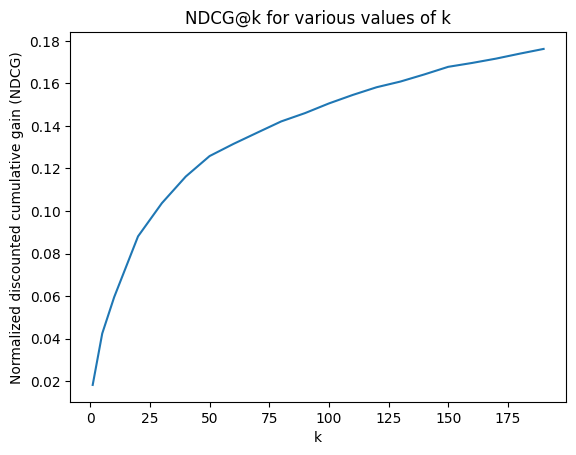

In [8]:
k_values = [1, 5] + list(range(10, 200, 10))
recalls = []
ndcgs = []
for k in k_values:
    # print("Mean Squared Error", mse)
    precision = tie.precision(k=k)
    # print("Precision", precision)
    recall = tie.recall(k=k)
    recalls.append(recall)
    # print("Recall", recall)
    ndcg = tie.normalized_discounted_cumulative_gain(k=k)
    ndcgs.append(ndcg)
    # print("Normalized Discounted Cumulative Gain", ndcg)

print("recalls", recalls)

plt.xlabel("k")
plt.ylabel("Normalized discounted cumulative gain (NDCG)")
plt.title("NDCG@k for various values of k")
plt.plot(k_values, ndcgs)

In [9]:
oilrig_techniques = {
    "T1047", "T1059.005", "T1124", "T1082",
    "T1497.001", "T1053.005", "T1027", "T1105",
    "T1070.004", "T1059.003", "T1071.001"
}
new_report_predictions = tie.predict_for_new_report(oilrig_techniques, c=0.5, regularization_coefficient=0.05)

print(new_report_predictions.sort_values(by="predictions", ascending=False).head(10))

           predictions  training_data  test_data  \
T1105         0.513513            1.0        0.0   
T1027         0.493395            1.0        0.0   
T1071.001     0.379125            1.0        0.0   
T1082         0.352350            1.0        0.0   
T1083         0.340111            0.0        0.0   
T1059.003     0.300826            1.0        0.0   
T1033         0.298678            0.0        0.0   
T1041         0.265720            0.0        0.0   
T1070.004     0.233528            1.0        0.0   
T1518.001     0.208502            0.0        0.0   

                            technique_name  
T1105                Ingress Tool Transfer  
T1027      Obfuscated Files or Information  
T1071.001                    Web Protocols  
T1082         System Information Discovery  
T1083         File and Directory Discovery  
T1059.003            Windows Command Shell  
T1033          System Owner/User Discovery  
T1041         Exfiltration Over C2 Channel  
T1070.004             

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 6262 samples in 0.003s...
[t-SNE] Computed neighbors for 6262 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6262
[t-SNE] Computed conditional probabilities for sample 2000 / 6262
[t-SNE] Computed conditional probabilities for sample 3000 / 6262
[t-SNE] Computed conditional probabilities for sample 4000 / 6262
[t-SNE] Computed conditional probabilities for sample 5000 / 6262
[t-SNE] Computed conditional probabilities for sample 6000 / 6262
[t-SNE] Computed conditional probabilities for sample 6262 / 6262
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.187531
[t-SNE] KL divergence after 10000 iterations: 0.847868


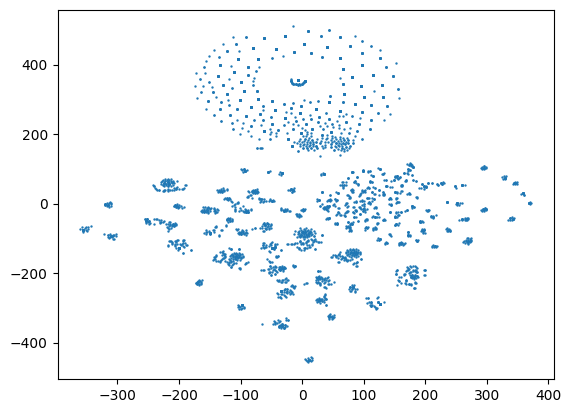

In [11]:
def make_tsne_embeddings(embeddings: np.ndarray) -> tuple[np.array, np.array]:
    """Create 2D representation of embeddings using t-SNE.

    Args:
        embeddings: an mxk array of m embeddings in k-dimensional space.

    Returns:
        A tuple of the form (x_1, x_2) where x_1 and x_2 are length m
        such that (x_1[i], x_2[i]) is the 2-dimensional point cotnaining the 2-dimensional
        repsresentation for embeddings[i, :].
    """
    tsne = sklearn.manifold.TSNE(
        n_components=2,
        perplexity=15,
        learning_rate="auto",
        # metric='cosine',
        # early_exaggeration=10.0,
        init='pca',
        verbose=True,
        n_iter=10000,
    )

    V_proj = tsne.fit_transform(embeddings)
    x = V_proj[:, 0]
    y = V_proj[:, 1]

    return x, y

U = tie.get_U()
x_1, x_2 = make_tsne_embeddings(U)

plt.scatter(x_1, x_2, s=0.5)
plt.show()